In [1]:
import os
import numpy as np
import firedrake as fd
import matplotlib.pyplot as plt
import hydrogym.firedrake as hgym
import ufl
from scipy import linalg
import control

from lti_system import control_vec, measurement_matrix, real_form
from step_response import LinearBDFSolver

Re = 100
eig_dir = f"./re{Re}_med_eig_output"

In [2]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{eig_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


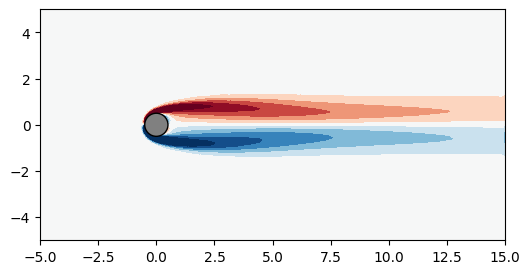

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


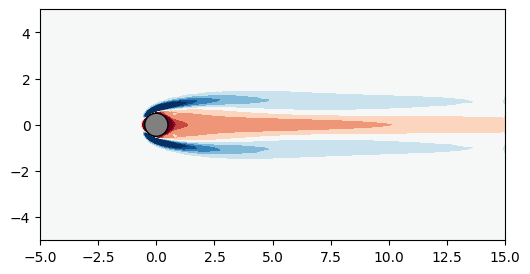

In [4]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure
qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
plt.show()

In [5]:
flow.compute_forces(qC)

((0.5939506798759142+0j), (-0.0002305149726099285+0j))

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


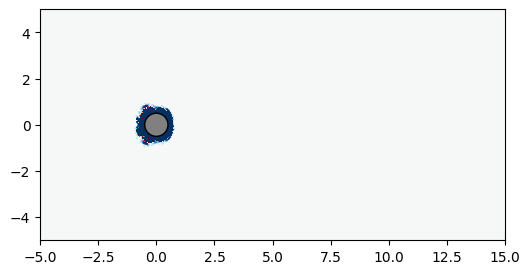

In [6]:
# 3. Derive the "measurement matrix"
# This is a field qM such that the inner product of qM with the flow field
# produces the same result as computing the observation (lift coefficient)

flow.q.assign(qB)
qM = measurement_matrix(flow)

flow.q.assign(qM)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [7]:
flow.inner_product(qM, qC)

(0.42466829554199437+0j)

# Load unstable global modes

In [8]:
evals = np.load(f"{eig_dir}/evals.npy")

# Load the set of eigenvectors
V_global = []
with fd.CheckpointFile(f"{eig_dir}/evecs.h5", "r") as chk:
    for i in range(len(evals)):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V_global.append(q)

W_global = []
with fd.CheckpointFile(f"{eig_dir}/adj_evecs.h5", "r") as chk:
    for i in range(len(evals)):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W_global.append(q)

# Sort by descending real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V_global = [V_global[i] for i in sort_idx]
W_global = [W_global[i] for i in sort_idx]

# Keep only the unstable modes
unstable_idx = np.where(evals.real > 0)[0]
V_global = [V_global[i] for i in unstable_idx]
W_global = [W_global[i] for i in unstable_idx]

ru = len(unstable_idx)  # Number of unstable modes

# Sort to real/imag parts (will still be biorthogonal, but won't diagonalize the system)
V_global_real = [fd.Function(flow.mixed_space) for _ in range(ru)]
W_global_real = [fd.Function(flow.mixed_space) for _ in range(ru)]

# Note that the usual factor of 1/2 is modified here to preserve normalization
for i in range(int(ru // 2)):
    V_global_real[2*i].assign((V_global[2*i] + V_global[2*i+1]) / np.sqrt(2))
    V_global_real[2*i+1].assign(1j * (V_global[2*i] - V_global[2*i+1]) / np.sqrt(2))
    W_global_real[2*i].assign((W_global[2*i] + W_global[2*i+1]) / np.sqrt(2))
    W_global_real[2*i+1].assign(1j * (W_global[2*i] - W_global[2*i+1]) / np.sqrt(2))

V_global, W_global = V_global_real, W_global_real

# Load impulse response data

In [9]:
snapshot_dir = "re100_impulse_output"

# Direct impulse response solution
X = []
m_d = 500  # Number of direct snapshots
with fd.CheckpointFile(f"{snapshot_dir}/dir_snapshots.h5", "r") as chk:
    for i in range(m_d):
        q = chk.load_function(flow.mesh, f"q_{i}")
        X.append(q)

# Adjoint impulse response solution
Y = []
m_a = 500  # Number of adjoint snapshots
with fd.CheckpointFile(f"{snapshot_dir}/adj_snapshots.h5", "r") as chk:
    for i in range(m_a):
        q = chk.load_function(flow.mesh, f"q_{i}")
        Y.append(q)



[[ 0.00000000e+00  7.33505535e-01  8.09225774e-03]
 [ 1.00000000e-02  1.68098203e+00 -1.41383847e-03]
 [ 2.00000000e-02  1.67946119e+00 -1.20308845e-04]
 ...
 [ 2.99960000e+02  3.14913693e-05  2.44409158e-05]
 [ 2.99970000e+02 -6.13854456e-06  2.31090341e-05]
 [ 2.99980000e+02  4.38467091e-05  9.39290385e-06]]


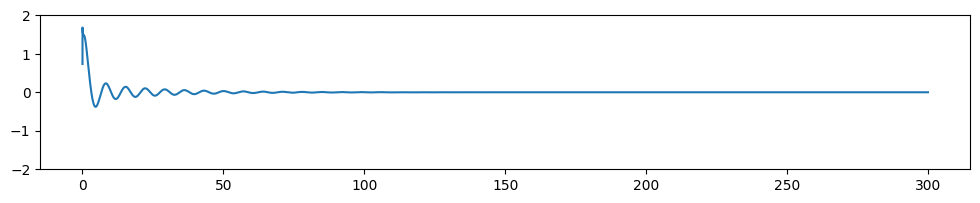

In [10]:
# Load data from model_reduction/step_response.py
step_response = np.load(f"{snapshot_dir}/long_response.npy")
print(step_response)
t, y = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(t, y, label="Full operator")
# ax.plot(t_full, CL_full, label="Full operator")
# ax.plot(np.arange(0, tf-dt, dt), CL, label="Stable subspace")
ax.set_ylim([-2, 2])
# ax.set_xlim([0, 100])
plt.show()

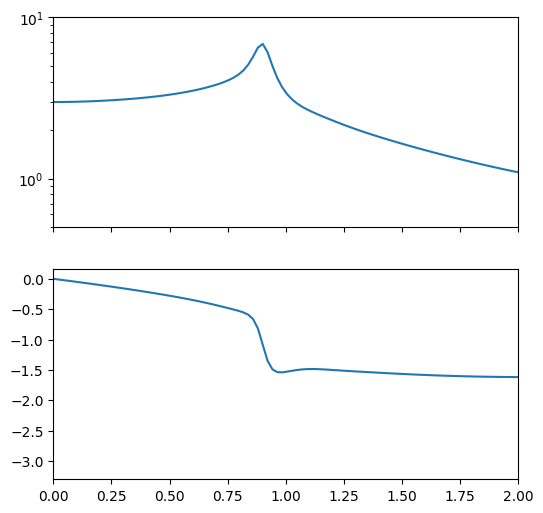

In [11]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(y)
f_dns = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
H_dns = np.sqrt(1 / 2 * np.pi) * np.fft.fft(y) / fs
# 
# H_dns = H_dns / H_dns[0]

f_dns = f_dns[:n//2]
H_dns = H_dns[:n//2]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(f_dns, np.abs(H_dns))
ax[0].set_ylim(0.5, 10)
ax[1].plot(f_dns, np.angle(H_dns))
ax[1].set_xlim(0, 2)
plt.show()


# BPOD

In [12]:
# Method of snapshots
R = np.zeros((m_a, m_a))
for i in range(m_a):
    for j in range(m_d):
        R[i, j] = flow.inner_product(X[j], Y[i]).real

(0.0, 20.0)

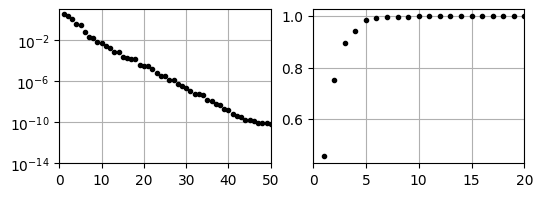

In [13]:
U, S, T = linalg.svd(R)

# Plot Hankel singular values
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].semilogy(1 + np.arange(len(S)), S, 'k.')
ax[0].set_xlim([0, 50])
ax[0].set_ylim([1e-14, 1e1])
ax[0].grid()
ax[1].plot(1 + np.arange(len(S)), np.cumsum(S) / np.sum(S), 'k.')
ax[1].grid()
ax[1].set_xlim([0, 20])

In [14]:
V_bpod = []   # direct modes: X @ T.T @ S ** (-1/2)
W_bpod = []   # adjoint modes: Y @ U @ S ** (-1/2)

rs = 20  # Number of BPOD modes for stable subspace
for i in range(rs):
    psi = fd.Function(flow.mixed_space)
    for j in range(m_d):
        psi.assign(psi + X[j] * T[i, j] / np.sqrt(S[i]))
    V_bpod.append(psi)

    psi = fd.Function(flow.mixed_space)
    for j in range(m_a):
        psi.assign(psi + Y[j] * U[j, i] / np.sqrt(S[i]))
    W_bpod.append(psi)


# Projection

In [15]:
r = ru + rs  # Total dimension of reduced-order model
Ar = np.zeros((r, r), dtype=complex)
Br = np.zeros((r, 1), dtype=Ar.dtype)
Cr = np.zeros((1, r), dtype=Ar.dtype)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

V = V_global + V_bpod
W = W_global + W_bpod
for i in range(r):
    for j in range(r):
        Ar[j, i] = flow.inner_product(A @ V[i], W[j])

    Br[i, 0] = flow.inner_product(qC, W[i])
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

# Ar, Br, Cr, Dr = map(np.conj, (Ar, Br, Cr, Dr))

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


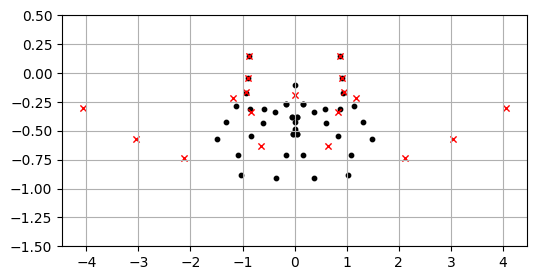

In [16]:
rom_evals = linalg.eigvals(Ar)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.set_ylim([-1.5, 0.5])
ax.grid()

In [17]:
# Au, Bu, Cu, Du, T = real_form(Ar[:ru, :ru].conj(), Br[:ru].conj(), Cr[:, :ru].conj(), Dr)
# # Au, Bu, Cu, Du, T = real_form(Ar[:ru, :ru], Br[:ru], Cr[:, :ru], Dr)
# A_hat = Ar.copy()
# A_hat[:ru, :ru] = Au
# B_hat = Br.copy()
# B_hat[:ru] = Bu
# C_hat = Cr.copy()
# C_hat[:, :ru] = Cu
# D_hat = Du
# A_hat, B_hat, C_hat, D_hat = map(np.real, (A_hat, B_hat, C_hat, D_hat))


# A_hat, B_hat, C_hat, D_hat, T_ = real_form(Ar.conj(), Br.conj(), Cr.conj(), Dr)

A_hat, B_hat, C_hat, D_hat = Ar, Br, Cr, Dr

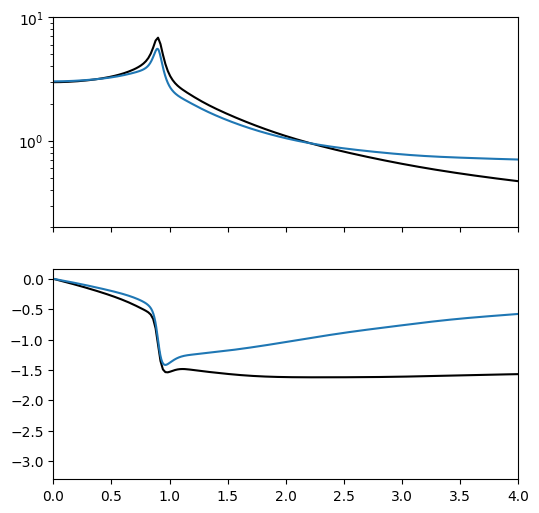

In [18]:
def H(s):
    return C_hat @ np.linalg.inv(s * np.eye(r) - A_hat) @ B_hat + D_hat

omega = 1j * np.linspace(0.01, 4.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(f_dns, np.abs(H_dns), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, omega[-1].imag)
ax[0].set_ylim(0.2, 10)
ax[1].plot(f_dns, np.angle(H_dns), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


# No control

In [19]:
data_no_act = np.load("re100_open_loop_output/no_actuation.npz")
t = data_no_act['t']
u = data_no_act['u'][:, None]
x = data_no_act['x']
y = data_no_act['y'][:, None]

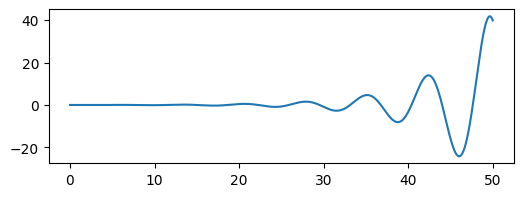

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, y)
plt.show()

### Kalman filter

In [21]:
dt = 0.01
m = 1  # Number of inputs
p = 1  # Number of outputs

# Zero-order hold discretization
A_kf = linalg.expm(A_hat * dt)
B_kf = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ B_hat
C_kf = C_hat
D_kf = D_hat

# A_kf, B_kf, C_kf, D_kf = map(np.conj, (A_kf, B_kf, C_kf, D_kf))

In [22]:
# Discrete Kalman filter

Qf = np.eye(r)
Rf = 1e-6 * np.eye(p)
L, _, E = control.dlqr(A_kf.T, C_kf.T, Qf, Rf)
L = L.T
print(L[:2])

[[-19.16185387]
 [-58.32767533]]


/home/firedrake/firedrake/lib/python3.10/site-packages/control/statefbk.py:552: ComplexWarning: Casting complex values to real discards the imaginary part
  A = np.array(args[0], ndmin=2, dtype=float)
/home/firedrake/firedrake/lib/python3.10/site-packages/control/statefbk.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  B = np.array(args[1], ndmin=2, dtype=float)


In [23]:
n_steps = len(t)

p = 1

z = np.zeros((n_steps, r))  # Kalman filter estimate
y_hat = np.zeros((n_steps, p))  # Kalman filter output

for i in range(1, n_steps):

    # Update the Kalman filter estimate 
    y_hat[i] = np.real(C_kf @ z[i-1])
    z[i] = A_kf @ z[i-1] + L @ (y[i] - y_hat[i])

/tmp/ipykernel_34319/3588810967.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  z[i] = A_kf @ z[i-1] + L @ (y[i] - y_hat[i])


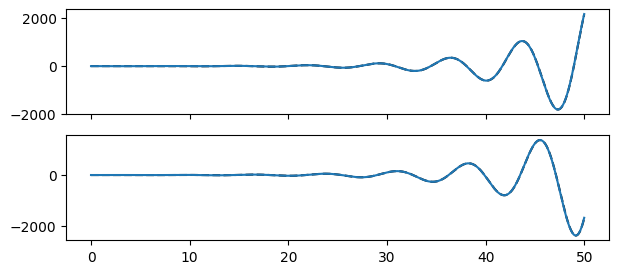

In [24]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)

# Transform from the eigenvector coordinates to our real-valued space
xr = np.sqrt(2) * np.array([x[:, 0].real, x[:, 0].imag]).T
ax[0].plot(t, xr[:, 0], 'k--')
ax[0].plot(t, z[:, 0])
# ax[0].plot(t, x_rom[:, 0].real)
ax[1].plot(t, xr[:, 1], 'k--')
ax[1].plot(t, z[:, 1])
# ax[1].plot(t, x_rom[:, 1].real)
plt.show()

### Controller design in the small-gain limit

See 6.2 in Barbagallo et al.

In [25]:
m = 1
p = 1

# Approximate low-gain limit with large R matrix
Q = np.eye(r)
R = 1e6 * np.eye(m)
K, _, E = control.lqr(A_hat, B_hat, Q, R)
print(K)

# Only try to control the two unstable modes
# K = np.zeros((m, r))
# Ku, _, E = control.lqr(A_hat[:ru, :ru], B_hat[:ru], Q[:ru, :ru], R)
# K[:, :2] = Ku
# print(Ku)
# print(E)

# Integral control on the actuation to drive the BC value to zero
ki = 1e-1

[[-3.00913605e-02 -1.13419142e-01  2.79789694e-05 -1.66514547e-05
  -7.59097214e-05 -2.93726963e-04  3.15951891e-05  1.62686889e-04
   1.42612900e-04  5.59235376e-06  3.51065153e-05 -5.81865805e-06
   5.10590114e-05 -1.63288931e-05 -4.07935185e-05  8.07543933e-05
  -1.85054609e-04 -8.69236202e-05  4.66008773e-05  7.94121539e-06
   7.25929985e-05 -2.68928748e-05]]


/home/firedrake/firedrake/lib/python3.10/site-packages/control/statefbk.py:408: ComplexWarning: Casting complex values to real discards the imaginary part
  A = np.array(args[0], ndmin=2, dtype=float)
/home/firedrake/firedrake/lib/python3.10/site-packages/control/statefbk.py:409: ComplexWarning: Casting complex values to real discards the imaginary part
  B = np.array(args[1], ndmin=2, dtype=float)


(0.1, 10)

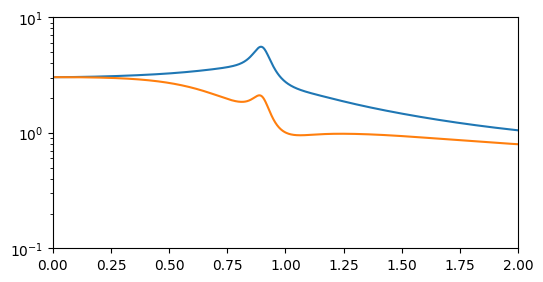

In [26]:
def H_cl(s):
    return C_hat @ np.linalg.inv(s * np.eye(r) - (A_hat + B_hat @ K)) @ B_hat + D_hat

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
# ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)
ax.set_ylim(0.1, 10)

### LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [27]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

tf = 50
n_steps = int(tf // dt)
CL_lqr = np.zeros(n_steps)
CD_lqr = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Reduced-order state
u = np.zeros((n_steps, m))  # Control signal

# # Integrated control signal (this is the BC value)
# c = np.zeros((n_steps, m))

rho = np.zeros(n_steps)
# rho = 0.0

flow.q.assign(solver.q)
for i in range(n_steps):
    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)]).real

    if i > 0:
        # Transform to the real-valued reduced state space

        # LQR control
        u[i] = -K @ x[i]

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += ki * rho[i-1]

        c.assign(u[i])
        rho[i] = rho[i-1] - dt * u[i]

    q = solver.step()
    flow.q.assign(q)
    CL_lqr[i], CD_lqr[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_lqr[i]:.4f}, CD={CD_lqr[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0069, CD=-0.0000
   u=[0.], rho=0.0
t=0.01, CL=0.0072, CD=-0.0000
   u=[0.0313351], rho=-0.00031335098829488804
t=0.02, CL=0.0076, CD=-0.0000
   u=[0.03210888], rho=-0.0006344398026337995
t=0.03, CL=0.0080, CD=-0.0000
   u=[0.0329144], rho=-0.0009635837545516815
t=0.04, CL=0.0084, CD=-0.0000
   u=[0.03372669], rho=-0.001300850643300077
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.03453736], rho=-0.0016462242919936788
t=0.06, CL=0.0093, CD=-0.0000
   u=[0.03534358], rho=-0.0019996600890125724
t=0.07, CL=0.0098, CD=-0.0000
   u=[0.03614435], rho=-0.002361103625558681
t=0.08, CL=0.0103, CD=-0.0000
   u=[0.03693933], rho=-0.002730496951725748
t=0.09, CL=0.0107, CD=-0.0000
   u=[0.03772837], rho=-0.0031077806786670497
t=0.10, CL=0.0112, CD=-0.0000
   u=[0.0385114], rho=-0.0034928946872433034
t=0.11, CL=0.0117, CD=-0.0000
   u=[0.03928837], rho=-0.0038857783692277715
t=0.12, CL=0.0123, CD=-0.0000
   u=[0.04005923], rho=-0.004286370711743371
t=0.13, CL=0.0128, CD=-0.0000
   u=[0.0408239

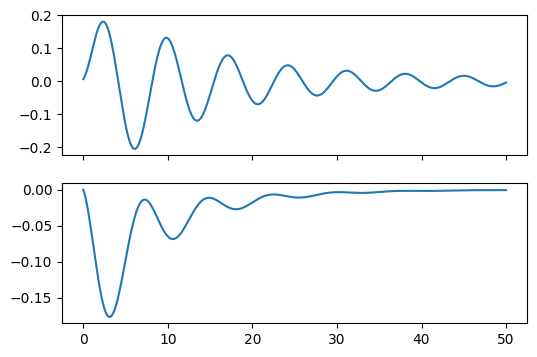

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_lqr)), CL_lqr)
# ax[0].set_ylim([-0.5, 0.5])

# ax[1].plot(dt * np.arange(len(rho)), x - xC * rho)
# ax[1].plot(dt * np.arange(len(rho)), x)
ax[1].plot(dt * np.arange(len(rho)), rho)

# Kalman filter

Still use full-state feedback control, but test KF implementation

In [29]:
dt = 0.01

# Zero-order hold discretization
A_kf = linalg.expm(Ar * dt)
B_kf = np.linalg.solve(Ar, (A_kf - np.eye(r))) @ Br
C_kf = Cr
D_kf = Dr

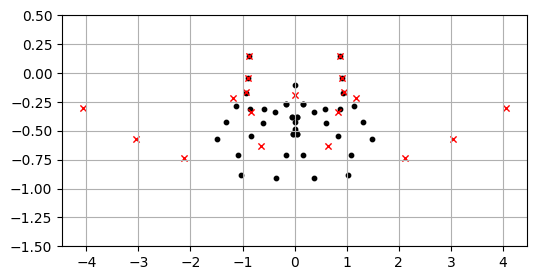

In [30]:
dt_evals = linalg.eigvals(A_kf)
ct_evals = np.log(dt_evals) / dt

# Compare the ct evals to the stability results
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(ct_evals.imag, ct_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.set_ylim([-1.5, 0.5])
ax.grid()

In [31]:
# # Forward Euler discretization
# A_kf = (Ar * dt + np.eye(r))
# B_kf = dt * Br
# C_kf = Cr
# D_kf = Dr

In [32]:

Qf = np.eye(r)
Rf = 1e-6 * np.eye(p)
L, _, _ = control.dlqr(A_kf.T, C_kf.T, Qf, Rf)
L = L.T

# Only try to detect the two unstable modes
# L = np.zeros((r, p))
# Lu, _, E = control.dlqr(A_kf[:ru, :ru].T, C_kf[:, :ru].T, Qf[:ru, :ru], Rf)
# L[:ru, :] = Lu.T
# print(Lu)
print(L)

[[-1.91618539e+01]
 [-5.83276753e+01]
 [ 4.25374467e-02]
 [ 1.39991533e-02]
 [ 1.41881813e-01]
 [-4.29872886e-02]
 [-2.83477344e-02]
 [-2.13720697e-02]
 [-9.24043620e-03]
 [ 3.27230832e-03]
 [-1.18218047e-02]
 [-8.67278283e-03]
 [-1.54207403e-02]
 [ 1.51199529e-02]
 [ 3.48967449e-03]
 [ 4.54141748e-02]
 [-1.94779672e-02]
 [-2.96033392e-03]
 [-6.82705038e-02]
 [ 2.97259640e-02]
 [-4.84973848e-02]
 [ 1.31709172e-01]]


/home/firedrake/firedrake/lib/python3.10/site-packages/control/statefbk.py:552: ComplexWarning: Casting complex values to real discards the imaginary part
  A = np.array(args[0], ndmin=2, dtype=float)
/home/firedrake/firedrake/lib/python3.10/site-packages/control/statefbk.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  B = np.array(args[1], ndmin=2, dtype=float)


In [33]:
n_steps = x.shape[0]
t = np.arange(n_steps) * dt

p = 1

xC = np.array([flow.inner_product(qC, W[j]) for j in range(r)]).real
z = np.zeros((n_steps, r))  # Kalman filter estimate
y_hat = np.zeros((n_steps, p))  # Kalman filter output
y = CL_lqr.real

z[0] = x[0]
# y_hat[0] = np.real(C_kf @ z[0]  + D_kf * u[0])

for i in range(1, n_steps):
    # Update the Kalman filter estimate 
    # y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i])
    y_hat[i] = np.real(C_kf @ z[i-1])
    z[i] = A_kf @ z[i-1] + B_kf @ u[i] + L @ (y[i] - y_hat[i])


/tmp/ipykernel_34319/1603340271.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  z[i] = A_kf @ z[i-1] + B_kf @ u[i] + L @ (y[i] - y_hat[i])


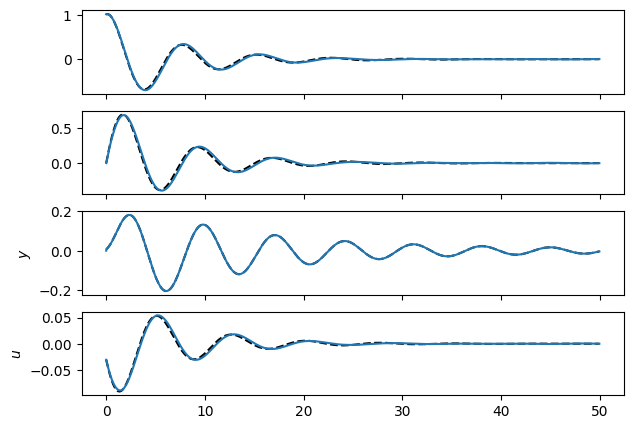

In [34]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(4, 1, figsize=(7, 5), sharex=True)

ax[0].plot(t, x[:, 0], 'k--')
ax[0].plot(t, z[:, 0])
# ax[0].set_ylim([-3, 3])
# ax[0].plot(t, x_rom[:, 0].real)
ax[1].plot(t, x[:, 1], 'k--')
ax[1].plot(t, z[:, 1])
# ax[1].set_ylim([-3, 3])
# ax[1].plot(t, x_rom[:, 1].real)
ax[2].plot(t, y, 'k--')
ax[2].plot(t, y_hat)
ax[2].set_ylabel(r"$y$")
ax[3].plot(t, x @ K.T, 'k--')
ax[3].plot(t, z @ K.T)
ax[3].set_ylabel(r"$u$")
plt.show()

# Full LQG

### Explicit forcing control

In [35]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC)
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

tf = 50.0
n_steps = int(tf // dt)
CL_lqg = np.zeros(n_steps)
CD_lqg = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=complex)  # Reduced state
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
u = np.zeros((n_steps, m))  # Control signal
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output

u_proj = np.zeros((n_steps, m))  # Control signal with true projection
y_proj = np.zeros((n_steps, p))  # Estimated output with true projection

# Integrated control signal (this is the BC value)
rho = np.zeros(n_steps)

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_lqg[i], CD_lqg[i] = map(np.real, flow.get_observations())

    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    # Estimate using true projection.. this should match y[i] reasonably well
    # y_est = np.real(Cr @ x[i-1] + Dr * u[i-1])
    y_proj[i] = np.real(Cr @ x[i])  # No feedthrough term here since we are using the homogeneous state

    y[i] = CL_lqg[i]
    if i > 0:
        # y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i-1])
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

        # # # No feedthrough term here since we are using the homogeneous state (??)
        # y_hat[i] = np.real(C_kf @ z[i-1])
        # z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

        # LQR control
        u_proj[i] = -np.real(K @ x[i])

        u[i] = -np.real(K @ z[i])  # <-- conjugate??

        # # Small integral control applied to the actuation to
        # # drive the BC value to zero
        # u[i] += 1e-1 * rho[i-1]

        c.assign(u[i])
        rho[i] = rho[i-1] - dt * u[i]

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_lqg[i]:.4f}, CD={CD_lqg[i]:.4f}")
        print(f"\tu={u[i]}, u_proj={u_proj[i]}, rho={rho[i]}\n\ty_hat={y_hat[i]} y_proj={y_proj[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0069, CD=-0.0000
	u=[0.], u_proj=[0.], rho=0.0
	y_hat=[0.] y_proj=[0.006922]
t=0.01, CL=0.0068, CD=-0.0000
	u=[-0.04900543], u_proj=[0.03226674], rho=0.0004900543305488334
	y_hat=[0.] y_proj=[0.00681381]
t=0.02, CL=0.0061, CD=0.0000
	u=[-0.05100149], u_proj=[0.0334744], rho=0.0010000692545152775
	y_hat=[0.00582315] y_proj=[0.0061861]
t=0.03, CL=0.0052, CD=0.0000
	u=[-0.04995354], u_proj=[0.03478301], rho=0.0014996046602638062
	y_hat=[0.00534356] y_proj=[0.00533556]


t=0.04, CL=0.0043, CD=0.0000
	u=[-0.04863682], u_proj=[0.03612192], rho=0.0019859728583991377
	y_hat=[0.00442949] y_proj=[0.00441329]
t=0.05, CL=0.0033, CD=0.0000
	u=[-0.04712471], u_proj=[0.03746643], rho=0.002457219962654595
	y_hat=[0.00350942] y_proj=[0.00347992]
t=0.06, CL=0.0024, CD=0.0000
	u=[-0.04552377], u_proj=[0.03880745], rho=0.002912457644547496
	y_hat=[0.00259765] y_proj=[0.00256033]
t=0.07, CL=0.0015, CD=0.0000
	u=[-0.04388507], u_proj=[0.0401415], rho=0.0033513083150387138
	y_hat=[0.00170823] y_proj=[0.00166485]
t=0.08, CL=0.0006, CD=0.0000
	u=[-0.04222973], u_proj=[0.0414672], rho=0.003773605591824356
	y_hat=[0.00084711] y_proj=[0.0007977]
t=0.09, CL=-0.0002, CD=0.0000
	u=[-0.040568], u_proj=[0.04278391], rho=0.00417928557300668
	y_hat=[1.5999338e-05] y_proj=[-3.95108787e-05]
t=0.10, CL=-0.0010, CD=0.0000
	u=[-0.03890602], u_proj=[0.04409132], rho=0.004568345747032081
	y_hat=[-0.00078489] y_proj=[-0.00084632]
t=0.11, CL=-0.0018, CD=0.0000
	u=[-0.03724821], u_proj=[0.045

/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


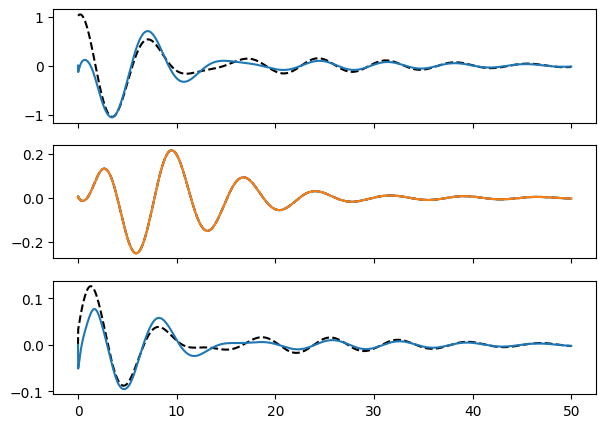

In [36]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, x[:, 0], 'k--')
ax[0].plot(t, z[:, 0])
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_proj)
ax[1].plot(t, y_hat)
ax[2].plot(t, u_proj, 'k--')
ax[2].plot(t, u)
plt.show()

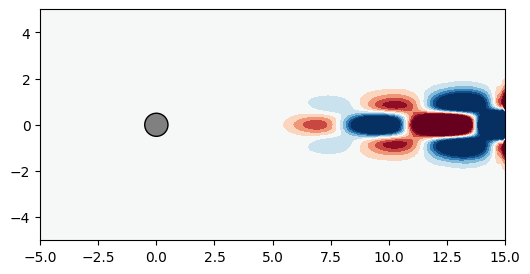

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

# Boundary condition control

1. Check Kalman filter on previous LQG results
2. Run closed-loop with LQG
3. Encapsulate in a script
4. Try with nonlinear DNS

In [47]:
# The full flow field with BCs is q = qH + qC * rho, where qH is the solution
# to the homogeneous problem with forcing.  Since the controller was designed
# based on qH, this is the value we want to use for the feedback: u = K * x, with
# x = W^T @ qH = W^T @ (q - qC * rho) the reduced state (in the eigenbasis).
# We can pre-compute the term (W^T @ qC) and subtract it from the full flow field
# projection at each step

xC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC)
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

tf = 50.0
n_steps = int(tf // dt)
CL_lqg = np.zeros(n_steps)
CD_lqg = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=complex)  # Reduced state
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
u = np.zeros((n_steps, m))  # Control signal
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output

u_proj = np.zeros((n_steps, m))  # Control signal with true projection
y_proj = np.zeros((n_steps, p))  # Estimated output with true projection

# Integrated control signal (this is the BC value)
rho = np.zeros(n_steps)

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_lqg[i], CD_lqg[i] = map(np.real, flow.get_observations())

    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    # Estimate using true projection.. this should match y[i] reasonably well
    # y_est = np.real(Cr @ x[i-1] + Dr * u[i-1])
    y_proj[i] = np.real(Cr @ x[i])  # No feedthrough term here since we are using the homogeneous state

    y[i] = CL_lqg[i]
    if i > 0:
        # # No feedthrough term here since we are using the homogeneous state (??)
        # y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i-1])
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

        # LQR control based on full-state feedback
        u_proj[i] = -np.real(K @ (x[i] - rho[i-1] * xC))

        # LQR control based on observer state
        # u[i] = -np.real(K @ (z[i] - rho[i-1] * xC))
        u[i] = u_proj[i]

        # Small integral control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        rho[i] = rho[i-1] - dt * u[i]
        flow.bcu_actuation[0].set_scale(rho[i])

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_lqg[i]:.4f}, CD={CD_lqg[i]:.4f}")
        print(f"\tu={u[i]}, u_proj={u_proj[i]}, rho={rho[i]}\n\ty_hat={y_hat[i]} y_proj={y_proj[i]}")

t=0.00, CL=0.0069, CD=-0.0000
	u=[0.], u_proj=[0.], rho=0.0
	y_hat=[0.] y_proj=[0.006922]
t=0.01, CL=0.0068, CD=-0.0000
	u=[0.03226674], u_proj=[0.03226674], rho=-0.00032266743382540703
	y_hat=[0.] y_proj=[0.00681381]
t=0.02, CL=0.0071, CD=-0.0000
	u=[0.03304883], u_proj=[0.03308109], rho=-0.0006531556946975769
	y_hat=[0.00582315] y_proj=[0.00694482]
t=0.03, CL=0.0073, CD=-0.0000
	u=[0.03385128], u_proj=[0.0339166], rho=-0.0009916685257328251
	y_hat=[0.00748786] y_proj=[0.00710599]
t=0.04, CL=0.0076, CD=-0.0000
	u=[0.03465664], u_proj=[0.03475581], rho=-0.0013382349256530325
	y_hat=[0.00800531] y_proj=[0.00727871]
t=0.05, CL=0.0078, CD=-0.0000
	u=[0.03545905], u_proj=[0.03559287], rho=-0.0016928253995663002
	y_hat=[0.0083028] y_proj=[0.00745793]
t=0.06, CL=0.0081, CD=-0.0000
	u=[0.03625653], u_proj=[0.03642581], rho=-0.0020553907038898546
	y_hat=[0.00856776] y_proj=[0.00764181]
t=0.07, CL=0.0083, CD=-0.0000
	u=[0.03704841], u_proj=[0.03725394], rho=-0.0024258747609235327
	y_hat=[0.0088

/tmp/ipykernel_34319/285497618.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  z[0] = x[0]
/tmp/ipykernel_34319/285497618.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  z[i] = A_kf @ z[i-1] + B_kf @ u[i] #+ L @ (y[i] - y_hat[i])


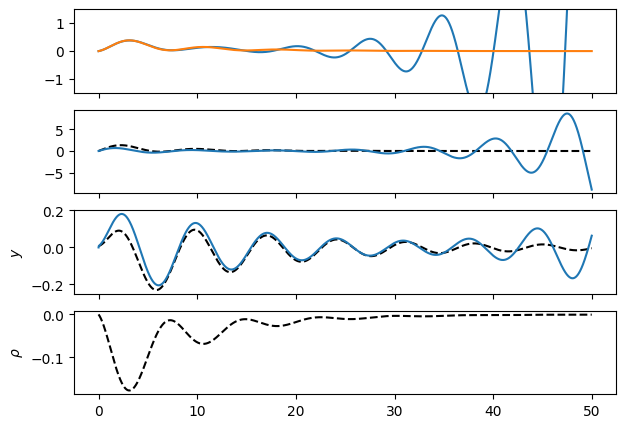

In [112]:
# Test Kalman filter reconstruction

n_steps = x.shape[0]
t = np.arange(n_steps) * dt

p = 1

xC = np.array([flow.inner_product(qC, W[j]) for j in range(r)]).real
z = np.zeros((n_steps, r))  # Kalman filter estimate
y_hat = np.zeros((n_steps, p))  # Kalman filter output

z[0] = x[0]
# y_hat[0] = np.real(C_kf @ z[0]  + D_kf * u[0])

for i in range(1, n_steps):
    # Update the Kalman filter estimate 
    # y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i])

    # y_hat[i] = np.real(C_kf @ (z[i-1] - rho[i-1] * xC))
    y_hat[i] = np.real(C_kf @ z[i-1])
    # y_hat[i] = np.real(C_kf @ x[i-1])
    z[i] = A_kf @ z[i-1] + B_kf @ u[i] #+ L @ (y[i] - y_hat[i])


t = np.arange(n_steps) * dt
fig, ax = plt.subplots(4, 1, figsize=(7, 5), sharex=True)

# ax[0].plot(t, x[:, 0], 'k--')
# ax[0].plot(t, z[:, 0])
ax[0].plot(t, x[:, 0] - z[:, 0])
ax[0].plot(t, rho * xC[0])
ax[0].set_ylim([-1.5, 1.5])
# ax[0].plot(t, x_rom[:, 0].real)
ax[1].plot(t, x[:, 1], 'k--')
ax[1].plot(t, z[:, 1])
# ax[1].set_ylim([-3, 3])
# ax[1].plot(t, x_rom[:, 1].real)
ax[2].plot(t, y, 'k--')
ax[2].plot(t, y_hat)
ax[2].set_ylabel(r"$y$")
# ax[3].plot(t, x @ K.T, 'k--')
# ax[3].plot(t, z @ K.T)
# ax[3].set_ylabel(r"$u$")
ax[3].plot(t, rho, 'k--')
ax[3].set_ylabel(r"$\rho$")
plt.show()

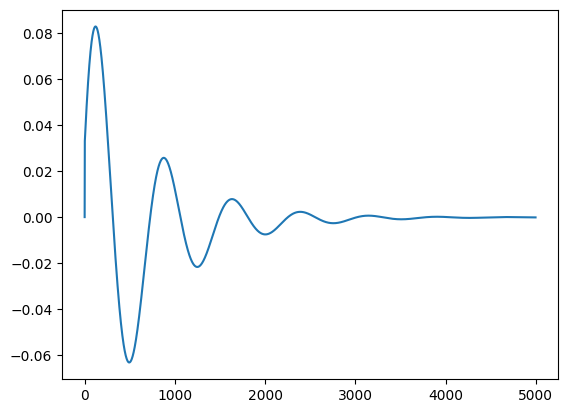

In [98]:
plt.plot(u)

In [90]:
xC

array([-2.18584574e+00, -4.75004746e+00, -4.67622681e-01,  1.72247024e-01,
        4.03760047e-01,  5.14202564e-01, -5.09524748e-02, -4.70941199e-02,
       -1.49586172e-02, -8.46014689e-04, -1.45438532e-03,  1.53510698e-04,
       -6.63176937e-04,  1.83769309e-05,  4.60811993e-05, -2.72032447e-04,
        7.15928796e-05, -1.44134544e-06,  2.29565567e-05, -1.10653673e-05,
        9.09713670e-07,  4.95715978e-06])